# Chapter 17: QAOA

---

**Prerequisites:**
- See `Chapter02_QuantumSoftware.ipynb` for installation instructions


In [2]:
# Setup and imports
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import StatevectorSampler 
from Chapter03_EngineeringOptimization_functions import (truss2x2,truss2x3,truss3x3)



## Simple unconstrained QUBO

c:\Users\ksure\anaconda3\envs\quantum\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:597: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
c:\Users\ksure\anaconda3\envs\quantum\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
c:\Users\ksure\anaconda3\envs\quantum\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


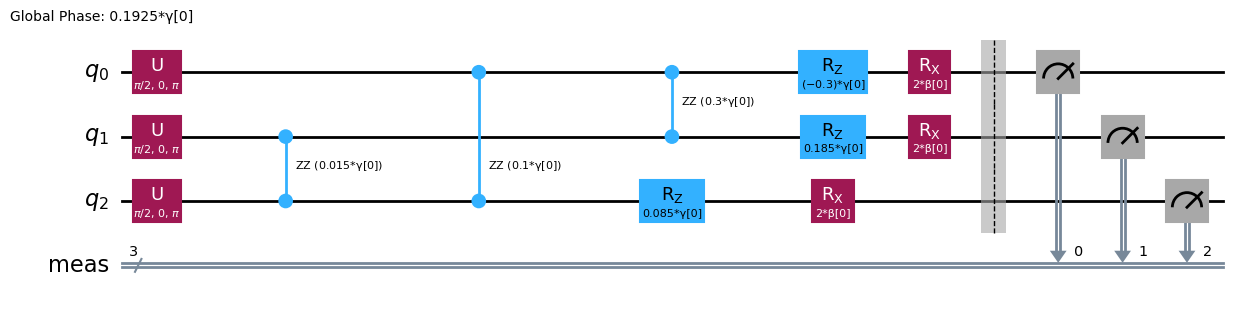

Optimal bitstring: 110
Optimal solution: a=0, b=1, c=1
QUBO value: -0.6699999999999999


In [3]:
# QUBO: minimize 0.6ab + 0.2ac + 0.03bc - 0.1a - 0.5b - 0.2c
# Define cost Hamiltonian from QUBO
# After variable substitution x = (1-Z)/2
# H_C = 0.15 Z_0Z_1 + 0.05 Z_0Z_2 + 0.0075 Z_1Z_2 + h_0 Z_0 + h_1 Z_1 + h_2 Z_2 + C
cost_hamiltonian = SparsePauliOp.from_list([
    ("ZZI", 0.0075),   # Z2 * Z1 * I
    ("ZIZ", 0.05),     # Z2 * I * Z0
    ("IZZ", 0.15),     # I * Z1 * Z0
    ("ZII", 0.0425),   # h2 (Z2)
    ("IZI", 0.0925),   # h1 (Z1)
    ("IIZ", -0.1500),  # h0 (Z0)
    ("III", -0.1925)   # Constant Offset C
])
qaoa = QAOA(
    sampler=StatevectorSampler(), # uses noiseless statevector simulator
    optimizer=COBYLA(maxiter=300),
    reps = 1
)

result = qaoa.compute_minimum_eigenvalue(cost_hamiltonian)

optimal_circuit = result.optimal_circuit
display(optimal_circuit.decompose(reps=2).draw('mpl'))

# Extract optimal solution
optimal_bitstring = max(result.eigenstate, key=result.eigenstate.get)
print(f"Optimal bitstring: {optimal_bitstring}")
c,b,a = [int(bit) for bit in optimal_bitstring]

print(f"Optimal solution: a={a}, b={b}, c={c}")

# Verify with classical QUBO evaluation
qubo_value = 0.6*a*b + 0.2*a*c + 0.03*b*c - 0.1*a - 0.5*b - 0.2*c
print(f"QUBO value: {qubo_value}")

## Max-Cut with Constraints

In [4]:
"""
MAX-CUT QAOA with Constrained Mixer
====================================
Graph: 5 nodes with edges: (1,2), (1,3), (2,4), (3,4), (3,5), (4,5)
Constraint: Nodes 1 and 4 must be in DIFFERENT sets  q_0 + q_3 = 1

Convert to Hamiltonian:
minimize H_C = 0.5 * sum_{(i,j) in E} Z_i*Z_j
# Pauli convention: rightmost = qubit 0, leftmost = qubit 4
"""

cost_hamiltonian = SparsePauliOp.from_list([
    ("IIIZZ", 0.5),  
    ("IIZIZ", 0.5),  
    ("IZIZI", 0.5),  
    ("IZIIZ", 0.5),   
    ("ZIZII", 0.5), 
    ("ZZIII", 0.5),   
])

# ============================================================================
# Define Constrained Mixer: Preserves q_0 + q_3 = 1
# ============================================================================
# XY mixer for qubits 0 and 3 (nodes 1 and 4)
# Standard X mixer for qubits 1, 2, 4 (nodes 2, 3, 5)

mixer_hamiltonian = SparsePauliOp.from_list([
    ("IXIIX", 0.5),   # X_0*X_3 (XY mixer component)
    ("IYIIY", 0.5),   # Y_0*Y_3 (XY mixer component)
    ("IIIXI", 1.0),   # X_1 (standard mixer)
    ("IIXII", 1.0),   # X_2 (standard mixer)
    ("XIIII", 1.0),   # X_4 (standard mixer)
])

initial_state = QuantumCircuit(5)
initial_state.x(0)  # q_0=1, satisfies constraint q_0 + q_3 = 1
initial_state.h([1, 2, 4])  # Superposition on unconstrained qubits

qaoa = QAOA(
    sampler=StatevectorSampler(),
    optimizer=COBYLA(maxiter=200),
    initial_state=initial_state,
    mixer=mixer_hamiltonian,
    reps=1
)

result = qaoa.compute_minimum_eigenvalue(cost_hamiltonian)

optimal_bitstring = max(result.eigenstate, key=result.eigenstate.get)
q4, q3, q2, q1, q0 = [int(bit) for bit in optimal_bitstring]

print(f"Optimal bitstring: |{optimal_bitstring}>")

q_vec = np.array([q0, q1, q2, q3, q4])
cut_edges = []

indexed = [(1,2), (1,3), (2,4), (3,4), (3,5), (4,5)]
edges = [(i-1, j-1) for i, j in indexed]
for i, j in edges:
    if q_vec[i] != q_vec[j]:
        cut_edges.append((i+1, j+1))

print(f"Cut value: {len(cut_edges)}")
print(f"Constraint check: q_0 + q_3  = {q0+q3} ")


c:\Users\ksure\anaconda3\envs\quantum\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:597: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
c:\Users\ksure\anaconda3\envs\quantum\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
c:\Users\ksure\anaconda3\envs\quantum\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


Optimal bitstring: |01100>
Cut value: 4
Constraint check: q_0 + q_3  = 1 
